In [32]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt

from visualization.utils import gradient_line

In [33]:
# Experiments where baseline was computed and where the metrics can be retrieved
POSTPROCESSING_EXPERIMENTS = {
    ('BPR', 'ML-1M'): 'metrics/ml-1m-bpr/c0.0__frozen_itememb__selection_relevance__k25__lr0.0001.json',
    ('DMF', 'ML-1M'): 'metrics/ml-1m-dmf/c0.0__frozen_itememb__selection_relevance__k100__lr0.0005.json',
    ('BPR', 'AMBAR'): 'metrics/ambar-bpr/c0.0__frozen_itememb__selection_relevance__k100__lr0.0001.json',
    ('DMF', 'AMBAR'): 'metrics/ambar-dmf/c0.0__frozen_itememb__selection_relevance__k25__lr0.0005.json',
}

EXPERIMENTS_TO_SHOW = {
    ('BPR', 'ML-1M'): {
        'lr': 'lr0.0001',
        'frozen_itememb': 'unfrozen_itememb',
        'k_candidates': 'k100',
        'alphas': [
            0.0,
            0.1,
            0.25,
            0.5,
            0.75,
            1.0
        ]
    },
    ('DMF', 'ML-1M'): {
        'lr': 'lr1e-05',
        'frozen_itememb': 'unfrozen_itememb',
        'k_candidates': 'k200',
        'alphas': [
            0.0,
            0.1,
            0.25,
            0.5,
            0.75,
            1.0
        ]
    },
    ('BPR', 'AMBAR'): {
        'lr': 'lr0.0001',
        'frozen_itememb': 'unfrozen_itememb',
        'k_candidates': 'k200',
        'alphas': [
            0.0,
            0.1,
            0.25,
            0.5,
            0.75,
            1.0
        ]
    },
    ('DMF', 'AMBAR'): {
        'lr': 'lr1e-05',
        'frozen_itememb': 'unfrozen_itememb',
        'k_candidates': 'k25',
        'alphas': [
            0.0,
            0.1,
            0.25,
            0.5,
            0.75,
            1.0
        ]
    }
}

data = {}

for subplot in EXPERIMENTS_TO_SHOW.keys():
    model_class, dataset = subplot
    data[subplot] = {
        'base_model': model_class,
        'dataset': dataset,
        'finetuned': {}
    }

    metrics_folder = f'{dataset.lower()}-{model_class.lower()}'

    lr = EXPERIMENTS_TO_SHOW[subplot]['lr']
    frozen_itememb = EXPERIMENTS_TO_SHOW[subplot]['frozen_itememb']
    k_candidates = EXPERIMENTS_TO_SHOW[subplot]['k_candidates']
    alphas = EXPERIMENTS_TO_SHOW[subplot]['alphas']

    try:
        with open(POSTPROCESSING_EXPERIMENTS[(model_class, dataset)]) as f:
            experiment_data = json.load(f)
            data[subplot]['base_model_metrics'] = {
                'ndcg': experiment_data['base_recommendations']['ndcg'],
                'jsd': experiment_data['base_recommendations']['jsd']
            }

            postprocessed_ndcgs = []
            postprocessed_jsds = []
            for l in experiment_data['postprocessed'].keys():
                postprocessed_ndcgs.append(experiment_data['postprocessed'][l]['ndcg'])
                postprocessed_jsds.append(experiment_data['postprocessed'][l]['jsd'])

            data[subplot]['postprocessed'] = {
                'ndcg': postprocessed_ndcgs,
                'jsd': postprocessed_jsds
            }
    except FileNotFoundError:
        print('Experiment with Postprocessing data not found, skipping!')

    for alpha in alphas:
        experiment_name = f'c{alpha}__{frozen_itememb}__selection_relevance__{k_candidates}__{lr}.json'
        experiment_file_loc = os.path.join('metrics', metrics_folder, experiment_name)
        try:
            with open(experiment_file_loc) as f:
                experiment_data = json.load(f)

                finetuned_ndcgs = []
                finetuned_jsds = []
                for epoch in experiment_data['finetuned'].keys():
                    finetuned_ndcgs.append(experiment_data['finetuned'][epoch]['ndcg'])
                    finetuned_jsds.append(experiment_data['finetuned'][epoch]['jsd'])

                data[subplot]['finetuned'][alpha] = {
                    'ndcg': finetuned_ndcgs,
                    'jsd': finetuned_jsds
                }
        except FileNotFoundError:
            print(f'Experiment {experiment_file_loc} not found, skipping!')


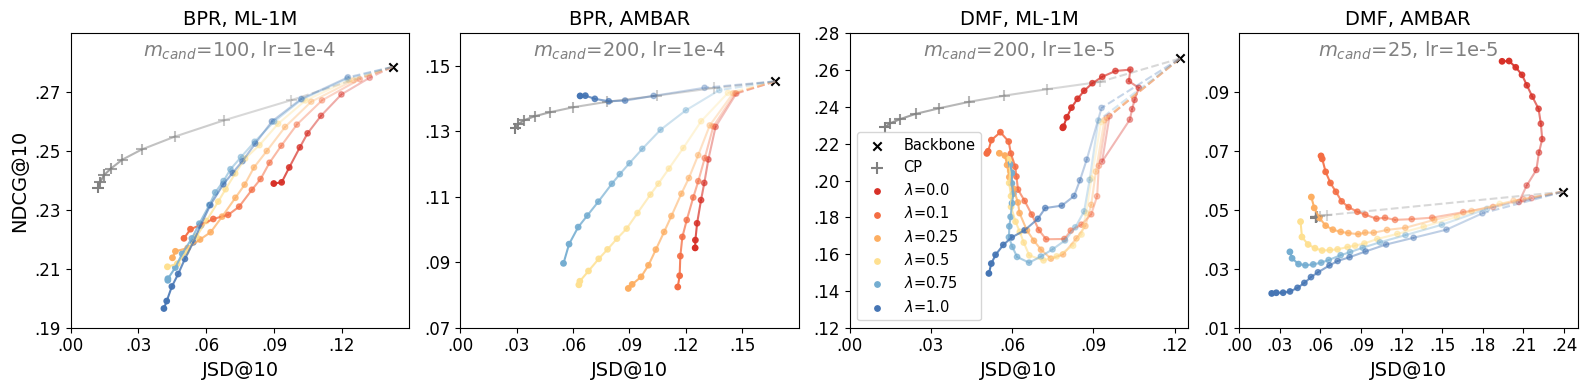

In [34]:
SUBPLOTS = [
    ('BPR', 'ML-1M'),
    ('BPR', 'AMBAR'),
    ('DMF', 'ML-1M'),
    ('DMF', 'AMBAR'),
]

JSD_RANGE = {
    ('BPR', 'ML-1M'): [0, 0.15],
    ('DMF', 'ML-1M'): [0, 0.125],
    ('BPR', 'AMBAR'): [0, 0.18],
    ('DMF', 'AMBAR'): [0, 0.25],
}
NDCG_RANGE = {
    ('BPR', 'ML-1M'): [0.19, 0.29],
    ('DMF', 'ML-1M'): [0.12, 0.28],
    ('BPR', 'AMBAR'): [0.07, 0.16],
    ('DMF', 'AMBAR'): [0.01, 0.11],
}

LR_LABELS = {
    'lr0.0001': '1e-4',
    'lr0.0005': '5e-4',
    'lr1e-05': '1e-5',
}

ALPHA_COLORS = {
    0.0: '#d73027',
    0.1: '#f46d43',
    0.25: '#fdae61',
    0.5: '#fee090',
    0.75: '#74add1',
    1.0: '#4575b4'
}

# Plotting

# Obtain 1x4 subplots
fig, axes = plt.subplots(1, 4, figsize=(4 * 4, 4))


for idx, (model, dataset) in enumerate(SUBPLOTS):
    subplot_data = data[(model, dataset)]

    ax = axes[idx]

    ax.set_title(f'{model}, {dataset}', fontsize=14)

    lr = EXPERIMENTS_TO_SHOW[(model, dataset)]['lr']
    k_candidates = EXPERIMENTS_TO_SHOW[(model, dataset)]['k_candidates']
    frozen = EXPERIMENTS_TO_SHOW[(model, dataset)]['frozen_itememb']
    if frozen == 'frozen_itememb':
        frozen_label = ', Frozen Item Emb.'
    else:
        frozen_label = ''  # Intentionally left blank

    fixed_params = f'$m_{{cand}}$={k_candidates[1:]}, lr={LR_LABELS[lr]}{frozen_label}'

    ax.text(0.5, 0.94, fixed_params, ha='center', va='center', transform=ax.transAxes, fontsize=14, color='gray')

    ax.set_xlabel('JSD@10', fontsize=14)
    if idx == 0:
        ax.set_ylabel('NDCG@10', fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x).lstrip('0')))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x).lstrip('0')))

    ax.set_xlim(*JSD_RANGE[(model, dataset)])
    ax.set_ylim(*NDCG_RANGE[(model, dataset)])

    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.round(np.arange(start, end, 0.03), 2))

    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.round(np.arange(start, end, 0.02), 2))

    starting_point = None
    # Plot Backbone Model
    if 'base_model_metrics' in subplot_data.keys():
        starting_point = [
            subplot_data['base_model_metrics']['jsd'],
            subplot_data['base_model_metrics']['ndcg']
        ]
        ax.scatter(
            starting_point[0],
            starting_point[1],
            marker='x', color='black', label='Backbone')
    # Plot postprocessing line
    if 'postprocessed' in subplot_data.keys():
        gradient_line(
            subplot_data['postprocessed']['jsd'],
            subplot_data['postprocessed']['ndcg'],
            ax,
            c='gray', marker='+', lbl='CP',
            starting_point=starting_point,
            scatter_size=65
        )

    # Plot finetuned lines
    for alpha in subplot_data['finetuned'].keys():
        alpha_data = subplot_data['finetuned'][alpha]

        # Get color for alpha
        color = ALPHA_COLORS[alpha]

        # Plot gradient line
        gradient_line(
            alpha_data['jsd'],
            alpha_data['ndcg'],
            ax,
            c=color, marker='o', lbl=f'$\lambda$={alpha}',
            starting_point=starting_point,
            threshold=0.005,
        )
    if idx == 2:
        ax.legend(fontsize=10.5)
        # ax.legend(fontsize=11, loc='center left', bbox_to_anchor=(0, 0.55))

# fig.legend()
# Reduce horizontal spacing by setting wspace to a smaller value
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)  # smaller wspace leads to less horizontal padding
plt.savefig('visualization/pdf/calitune_all.pdf')
plt.show()